# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

In [2]:
# structure to save accuracy results
allAccuracy = []

In [3]:
savePath = ''

## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
testset = datasets.MNIST('./data', download=True, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [5]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [8]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [9]:
lossDataBaseline, accDataBaseline = trainNN(model)

Epoch 0 - Training loss: 0.6963553194080472
Testing Loss  = 0.3406923157963783
Epoch 1 - Training loss: 0.30183408547507223
Testing Loss  = 0.26975088485866594
Epoch 2 - Training loss: 0.23775207602878665
Testing Loss  = 0.22387775804871207
Epoch 3 - Training loss: 0.19767608600990166
Testing Loss  = 0.19252156418789723
Epoch 4 - Training loss: 0.16493603661704018
Testing Loss  = 0.1789922620507942
Epoch 5 - Training loss: 0.14325404105245915
Testing Loss  = 0.16827023961836365
Epoch 6 - Training loss: 0.12578543992069982
Testing Loss  = 0.1389531795481208
Epoch 7 - Training loss: 0.11233685547819414
Testing Loss  = 0.1253613115401025
Epoch 8 - Training loss: 0.09988883107214633
Testing Loss  = 0.12397749285409405
Epoch 9 - Training loss: 0.09129095545081455
Testing Loss  = 0.11972375015378188
Epoch 10 - Training loss: 0.08235181512339684
Testing Loss  = 0.10956386133886067
Epoch 11 - Training loss: 0.07607773912991957
Testing Loss  = 0.11461658045578345
Epoch 12 - Training loss: 0.070

In [10]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [11]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

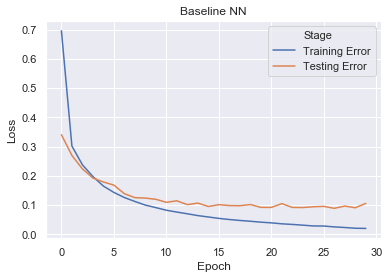

In [12]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

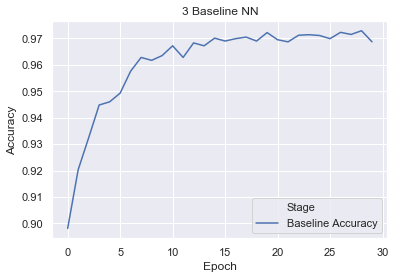

In [13]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [14]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [15]:
correctCount / allCount

0.9721

In [16]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_complex = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [17]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_complex(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [18]:
lossDataComplex, accDataComplex = trainNN(model_complex)

Epoch 0 - Training loss: 0.9044183488277828
Testing Loss  = 0.36565407408270867
Epoch 1 - Training loss: 0.3071440703156964
Testing Loss  = 0.2716334739783008
Epoch 2 - Training loss: 0.23211712808922277
Testing Loss  = 0.22426608968882045
Epoch 3 - Training loss: 0.18033433647449973
Testing Loss  = 0.1915512556435576
Epoch 4 - Training loss: 0.14763174733132733
Testing Loss  = 0.16163778420134334
Epoch 5 - Training loss: 0.12142528819463327
Testing Loss  = 0.13743253899322952
Epoch 6 - Training loss: 0.10562780933321246
Testing Loss  = 0.12791287381747726
Epoch 7 - Training loss: 0.09327449021346466
Testing Loss  = 0.11633332416557582
Epoch 8 - Training loss: 0.08214945758721504
Testing Loss  = 0.1124824697958531
Epoch 9 - Training loss: 0.07179197261664931
Testing Loss  = 0.11006531278917174
Epoch 10 - Training loss: 0.06454489759676864
Testing Loss  = 0.10201824147396596
Epoch 11 - Training loss: 0.05611743463341461
Testing Loss  = 0.11585245129598934
Epoch 12 - Training loss: 0.051

In [19]:
accDataComplex = [[row[0], row[1], 'More nodes and layers Accuracy'] for row in accDataComplex]

In [20]:
lossDataComplex = pd.DataFrame.from_records(lossDataComplex, columns=["Epoch", "Loss", "Stage"])
accDataComplex = pd.DataFrame.from_records(accDataComplex, columns=["Epoch", "Accuracy", "Stage"])

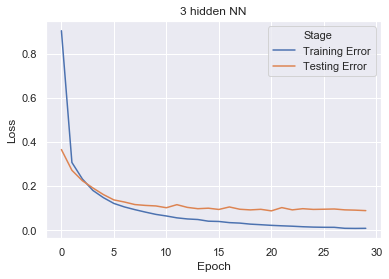

In [21]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataComplex
#     ).set_title('3 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataComplex
    ).set_title('3 hidden NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_3hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 hidden NN')

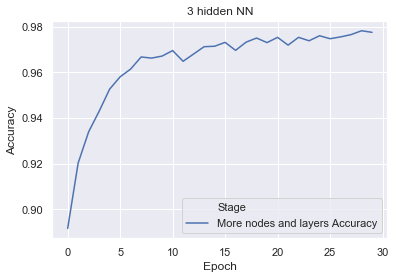

In [22]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataComplex
    ).set_title('3 hidden NN')

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





In [23]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [24]:
correctCount / allCount

0.9779

In [25]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_dropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [26]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_dropout(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [27]:
lossDataDropout, accDataDropout = trainNN(model_dropout)

Epoch 0 - Training loss: 0.9493379982097832
Testing Loss  = 0.38456109650195786
Epoch 1 - Training loss: 0.3132631238049749
Testing Loss  = 0.2664942424863007
Epoch 2 - Training loss: 0.2280305636822796
Testing Loss  = 0.2084758750572326
Epoch 3 - Training loss: 0.1793453328030379
Testing Loss  = 0.19185194949720316
Epoch 4 - Training loss: 0.1510915217892555
Testing Loss  = 0.15696117296150536
Epoch 5 - Training loss: 0.13289541181634226
Testing Loss  = 0.14220808977913704
Epoch 6 - Training loss: 0.11546402499484627
Testing Loss  = 0.13604439848405162
Epoch 7 - Training loss: 0.1039292188575658
Testing Loss  = 0.1434915089967904
Epoch 8 - Training loss: 0.09663917013513082
Testing Loss  = 0.12978179075986526
Epoch 9 - Training loss: 0.08795907956731441
Testing Loss  = 0.11317220448878161
Epoch 10 - Training loss: 0.07899380057795292
Testing Loss  = 0.11576849729961651
Epoch 11 - Training loss: 0.07494275820205736
Testing Loss  = 0.11190680769171304
Epoch 12 - Training loss: 0.0672941

In [28]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]

In [29]:
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

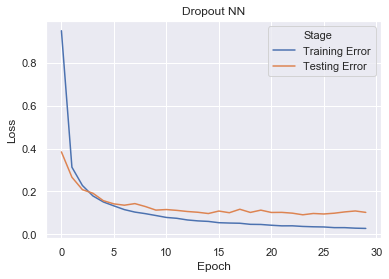

In [30]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

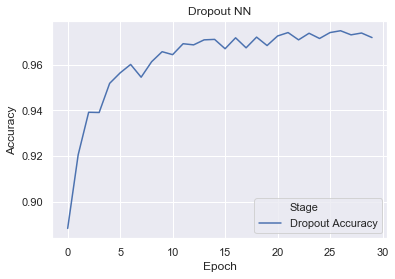

In [31]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [32]:
accData = accDataBaseline.copy()
accData = accData.append(accDataComplex)
accData = accData.append(accDataDropout)

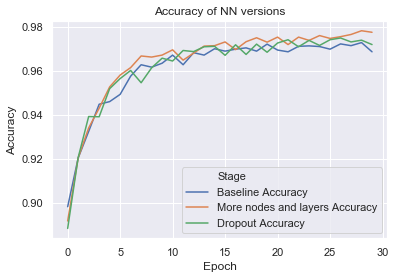

In [33]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig(savePath + "NN_MNIST_all_accuracy.png", dpi=100)

In [34]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [35]:
correctCount / allCount

0.9779

In [36]:
allAccuracy.append(['Neural Network', 'MNIST', correctCount / allCount])

### Credit default dataset

In [37]:
# load dataset
creditDataDf = pd.read_excel(savePath + './data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [38]:
print(sum(creditDataDf['default payment next month']))
print(len(creditDataDf))
print(sum(creditDataDf['default payment next month'])/len(creditDataDf))


6636
30000
0.2212


In [39]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [40]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [41]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [42]:
dfColumns = creditDataDf.columns

In [43]:
# balance the dataset
ros = RandomOverSampler(random_state=37)
creditDataDf, y = ros.fit_resample(creditDataDf, y)

In [44]:
creditDataDf = pd.DataFrame(creditDataDf, columns=dfColumns)

In [45]:
print(sum(y)/len(y))

0.5


In [46]:
# normalize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

In [48]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [49]:
sum(y_train)/len(y_train)

0.5023909045310149

In [50]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))
y_val_tensor = torch.tensor(y_val.values.astype(np.int))

In [51]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [52]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

7477 9346 29905


In [53]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader2 = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [54]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [55]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [56]:
def trainTabNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # optimizer = optim.Adam(model.parameters(), lr=0.01)
    time0 = time()
    epochs = 100
    lossData = []
    accData=[]
    for e in range(epochs):
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [57]:
lossDataBaseline, accDataBaseline = trainTabNN(modelTabBaseline)

Epoch 0 - Training loss: 0.6748208855716591
Testing Loss  = 0.6315797567367554
Testing Accuracy  = 0.6475859301859035
Epoch 1 - Training loss: 0.6060077907820033
Testing Loss  = 0.5898044109344482
Testing Accuracy  = 0.6966697873478668
Epoch 2 - Training loss: 0.589457451660409
Testing Loss  = 0.5811731219291687
Testing Accuracy  = 0.7033569613481343
Epoch 3 - Training loss: 0.5840637997811676
Testing Loss  = 0.5767785906791687
Testing Accuracy  = 0.7050956265882038
Epoch 4 - Training loss: 0.5799626220240552
Testing Loss  = 0.5742657780647278
Testing Accuracy  = 0.7032232178681289
Epoch 5 - Training loss: 0.5766554872194926
Testing Loss  = 0.5689857602119446
Testing Accuracy  = 0.7075030092283001
Epoch 6 - Training loss: 0.5738257507228444
Testing Loss  = 0.5661823153495789
Testing Accuracy  = 0.7095091614283804
Epoch 7 - Training loss: 0.5709118756473573
Testing Loss  = 0.5629090070724487
Testing Accuracy  = 0.7112478266684499
Epoch 8 - Training loss: 0.5684892659385999
Testing Loss 

In [58]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, testloader2, criterion)

In [59]:
correctCount/allCount

0.7240530708324416

In [60]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

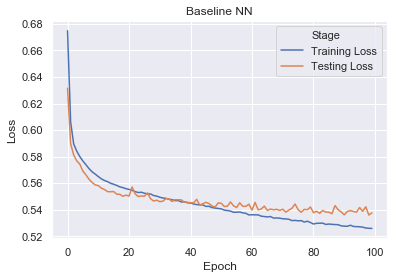

In [61]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Baseline NN')

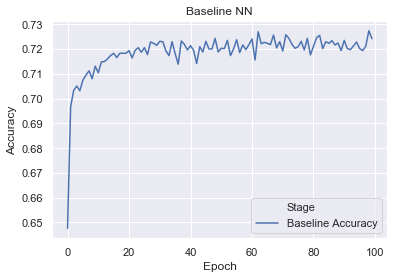

In [62]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

In [63]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2

modelTabLarge = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [64]:
lossDataLarge, accDataLarge = trainTabNN(modelTabLarge)

Epoch 0 - Training loss: 0.6946255037417779
Testing Loss  = 0.6931198835372925
Testing Accuracy  = 0.49565333689982616
Epoch 1 - Training loss: 0.6927131911118826
Testing Loss  = 0.692533552646637
Testing Accuracy  = 0.4973920021398957
Epoch 2 - Training loss: 0.6918861767929844
Testing Loss  = 0.6910335421562195
Testing Accuracy  = 0.6161562123846462
Epoch 3 - Training loss: 0.6899461059743522
Testing Loss  = 0.6879719495773315
Testing Accuracy  = 0.6162899558646516
Epoch 4 - Training loss: 0.6835228697611735
Testing Loss  = 0.6759085655212402
Testing Accuracy  = 0.5922161294636886
Epoch 5 - Training loss: 0.6567740532068106
Testing Loss  = 0.6291677951812744
Testing Accuracy  = 0.660826534706433
Epoch 6 - Training loss: 0.6094965804845859
Testing Loss  = 0.5966105461120605
Testing Accuracy  = 0.6854353350274174
Epoch 7 - Training loss: 0.5945918197051073
Testing Loss  = 0.5898452401161194
Testing Accuracy  = 0.6921225090276849
Epoch 8 - Training loss: 0.5889323307917669
Testing Loss 

In [65]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [66]:
correctCount/allCount

0.7179542050074899

In [67]:
accDataLarge = [[row[0], row[1], '5 hidden Accuracy'] for row in accDataLarge]
lossDataLarge = pd.DataFrame.from_records(lossDataLarge, columns=["Epoch", "Loss", "Stage"])
accDataLarge = pd.DataFrame.from_records(accDataLarge, columns=["Epoch", "Accuracy", "Stage"])

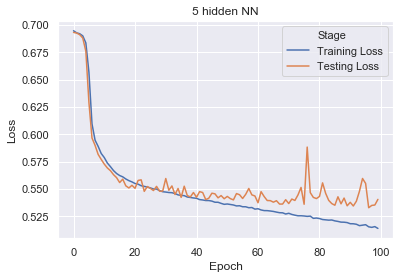

In [68]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataLarge
    # ).set_title('5 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataLarge
    ).set_title('5 hidden NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_5hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '5 hidden NN')

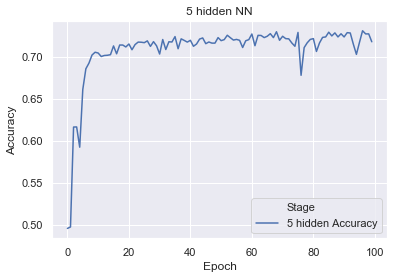

In [69]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataLarge
    ).set_title('5 hidden NN')

In [70]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2
drop_out = 0.2

modelTabDropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [71]:
lossDataDropout, accDataDropout = trainTabNN(modelTabDropout)

Epoch 0 - Training loss: 0.6952610070634092
Testing Loss  = 0.6933584213256836
Testing Accuracy  = 0.49565333689982616
Epoch 1 - Training loss: 0.6931753294844912
Testing Loss  = 0.6930459141731262
Testing Accuracy  = 0.5048816370201953
Epoch 2 - Training loss: 0.6931293624588567
Testing Loss  = 0.6932284832000732
Testing Accuracy  = 0.49819446301992776
Epoch 3 - Training loss: 0.6930879236031802
Testing Loss  = 0.6933640241622925
Testing Accuracy  = 0.49538584993981544
Epoch 4 - Training loss: 0.6930522921248379
Testing Loss  = 0.6929389238357544
Testing Accuracy  = 0.5147786545405911
Epoch 5 - Training loss: 0.6929600219695996
Testing Loss  = 0.6930612325668335
Testing Accuracy  = 0.5006018456600241
Epoch 6 - Training loss: 0.6929126767775952
Testing Loss  = 0.6928367614746094
Testing Accuracy  = 0.5171860371806875
Epoch 7 - Training loss: 0.692711885413553
Testing Loss  = 0.6931015253067017
Testing Accuracy  = 0.49685702821987426
Epoch 8 - Training loss: 0.6925887414532849
Testing L

In [72]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabDropout, testloader2, criterion)

In [73]:
correctCount/allCount

0.7139952921035737

In [74]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

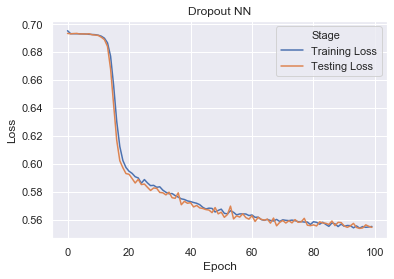

In [75]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

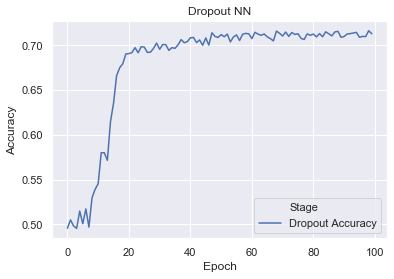

In [76]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [77]:
accData = accDataBaseline.copy()
accData = accData.append(accDataLarge)
accData = accData.append(accDataDropout)

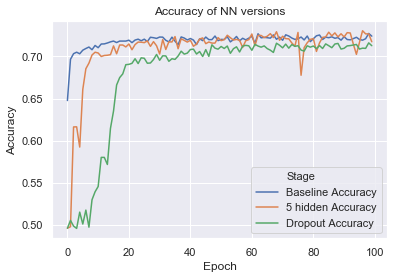

In [78]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig(savePath + "NN_CREDIT_all_accuracy.png", dpi=100)

In [79]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [80]:
allAccuracy.append(['Neural Network', 'Credit', correctCount / allCount])

## Decision tree

### MNIST dataset

In [81]:
trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)

In [82]:
X_train_MNIST = trainset.data.numpy()
X_test_MNIST = testset.data.numpy()

In [83]:
y_train_MNIST = trainset.targets.numpy()
y_test_MNIST = testset.targets.numpy()

In [84]:
np.bincount(y_train_MNIST) + np.bincount(y_test_MNIST)

array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958])

In [85]:
print(X_train_MNIST.shape)
print(y_train_MNIST.shape)

(60000, 28, 28)
(60000,)


In [86]:
X_train_MNIST_reshaped = X_train_MNIST.reshape((60000, 784))
X_test_MNIST_reshaped = X_test_MNIST.reshape((10000, 784))

In [87]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
gridSearchTree.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 13.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [88]:
gridSearchTree.best_params_

{'max_depth': 15, 'min_samples_leaf': 5}

In [89]:
preds = gridSearchTree.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

0.8833


In [90]:
allAccuracy.append(['Decision Tree', 'MNIST', accuracy_score(preds, y_test_MNIST)])

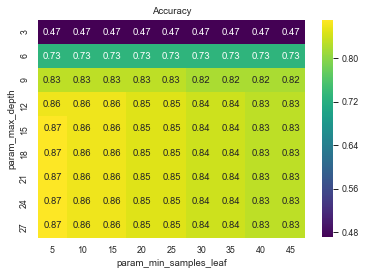

In [91]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_accuracy.png", dpi=100)

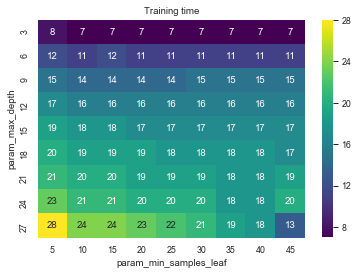

In [92]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 0)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_train-time.png", dpi=100)

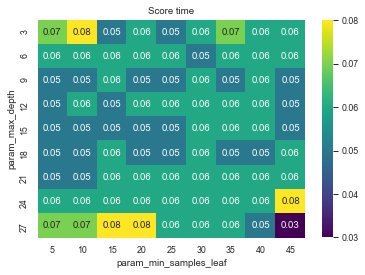

In [93]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_CV_score-time.png", dpi=100)

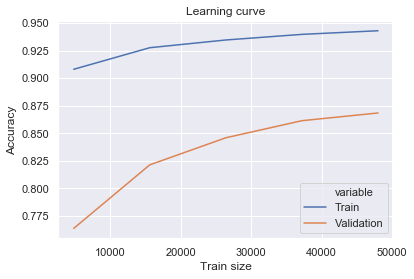

In [94]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')
sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "DT_MNIST_learning-curve.png", dpi=100)

### Credit default dataset

In [95]:
np.bincount(y_train) + np.bincount(y_test) + np.bincount(y_val)

array([23364, 23364])

In [96]:
# concatenate dfs
X_train = pd.concat([X_train,X_val], axis=0)
y_train = np.concatenate([y_train,y_val], axis=0)
print(X_train.shape)
print(y_train.shape)

(37382, 30)
(37382,)


In [97]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=2, scoring='accuracy'
    )
gridSearchTree.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   26.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [98]:
preds = gridSearchTree.predict(X_test)
probs = gridSearchTree.predict_proba(X_test)
print(accuracy_score(preds, y_test))

0.8030173336186603


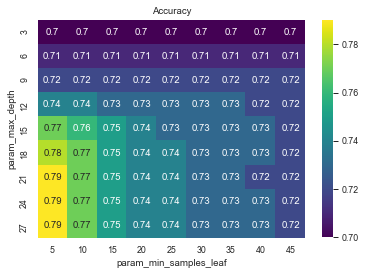

In [99]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_accuracy.png", dpi=100)

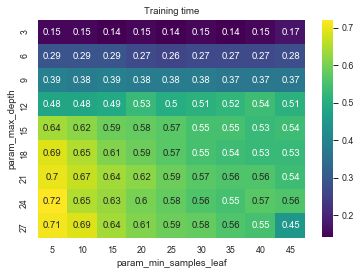

In [100]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_training-time.png", dpi=100)

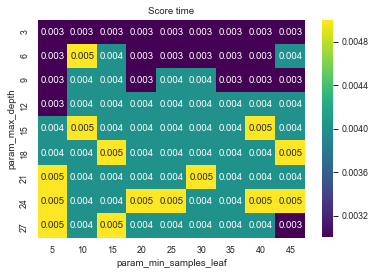

In [101]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_score-time.png", dpi=100)

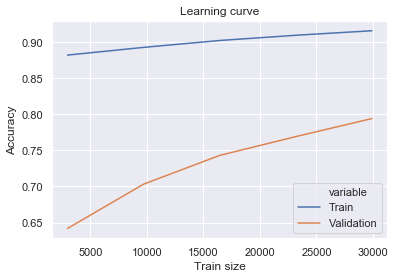

In [102]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "DT_CREDIT_learning-curve.png", dpi=100)

In [103]:
preds = gridSearchTree.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Decision Tree', 'Credit', accuracy_score(preds, y_test)])

0.8030173336186603


In [104]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9779], ['Neural Network', 'Credit', 0.7179542050074899], ['Decision Tree', 'MNIST', 0.8833], ['Decision Tree', 'Credit', 0.8030173336186603]]


## Boosting

### MNIST

In [105]:
param_grid = {'max_depth': np.arange(5, 30, 5), 'n_estimators': np.arange(10, 50, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=4), param_grid, n_jobs=4, verbose=3, scoring='accuracy', cv=2
    )
gridSearchBoosting.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 36.9min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 71.2min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'n_estimators': array([10, 20, 30,

In [106]:
gridSearchBoosting.best_params_

{'max_depth': 10, 'n_estimators': 40}

In [107]:
preds = gridSearchBoosting.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['Boosting', 'MNIST', accuracy_score(preds, y_test_MNIST)])

0.973


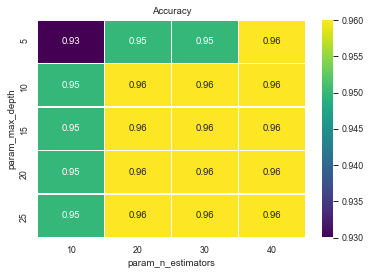

In [108]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_accuracy.png", dpi=100)

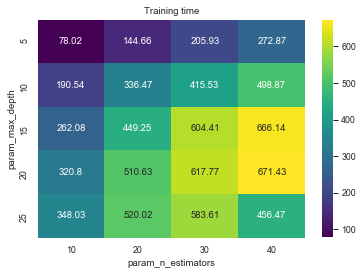

In [109]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_train-time", dpi=100)

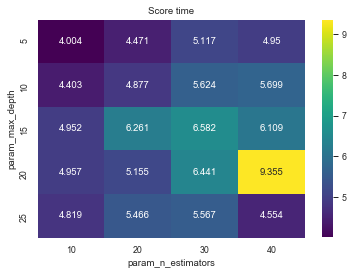

In [110]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_score-time.png", dpi=100)

In [111]:
bestModel = xgb.XGBClassifier(**gridSearchBoosting.best_params_, nthreads=4)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=4,
                                            verbose=5
                                            )

[learning_curve] Training set sizes: [ 3000  9750 16500 23250 30000]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of  10 | elapsed:  4.7min remaining: 18.6min
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed: 10.6min remaining: 10.6min
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed: 15.7min remaining:  3.9min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 24.1min finished


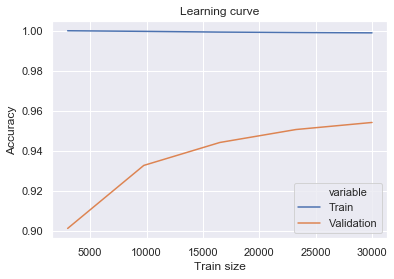

In [112]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "BOOSTING_MNIST_learning-curve.png", dpi=100)

### Credit default

In [113]:
param_grid = {'max_depth': np.arange(5, 30, 5), 'n_estimators': np.arange(10, 50, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=4), param_grid, n_jobs=4, verbose=3, scoring='accuracy', cv=2
    )
gridSearchBoosting.fit(X_train, y_train)


Fitting 2 folds for each of 20 candidates, totalling 40 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   27.5s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': array([ 5, 10, 15, 20, 25]),
                         'n_estimators': array([10, 20, 30,

In [114]:
preds = gridSearchBoosting.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Boosting', 'Credit', accuracy_score(preds, y_test)])
print(gridSearchBoosting.best_params_)

0.9238176760111277
{'max_depth': 25, 'n_estimators': 40}


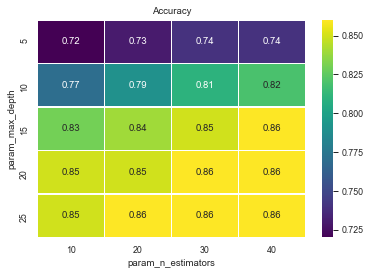

In [115]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_accuracy.png", dpi=100)

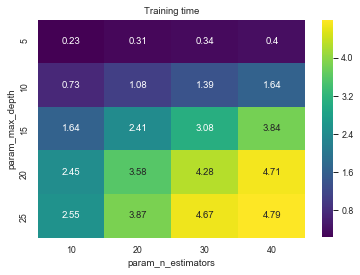

In [116]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_training-time.png", dpi=100)

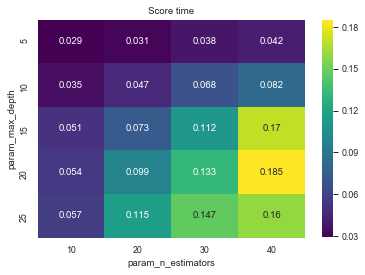

In [117]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_score-time.png", dpi=100)

In [118]:
bestModel = xgb.XGBClassifier(**gridSearchBoosting.best_params_, nthreads=4)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=4,
                                            verbose=5
                                            )

[learning_curve] Training set sizes: [ 1869  6074 10280 14485 18691]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of  10 | elapsed:    2.2s remaining:    9.0s
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed:    8.2s remaining:    2.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   12.9s finished


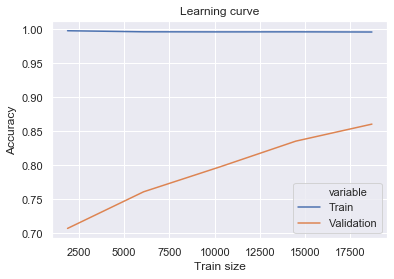

In [119]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "BOOSTING_CREDIT_learning-curve.png", dpi=100)

In [120]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9779], ['Neural Network', 'Credit', 0.7179542050074899], ['Decision Tree', 'MNIST', 0.8833], ['Decision Tree', 'Credit', 0.8030173336186603], ['Boosting', 'MNIST', 0.973], ['Boosting', 'Credit', 0.9238176760111277]]


## KNN

### MNIST

In [121]:
param_grid = {'n_neighbors': np.arange(5, 25, 5), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
kNN.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = kNN.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['KNN', 'MNIST', accuracy_score(preds, y_test_MNIST)])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed: 110.4min remaining: 36.8min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 110.5min finished
0.9691


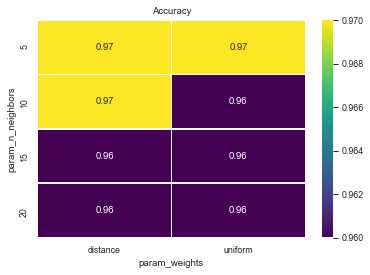

In [122]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_accuracy.png", dpi=100)

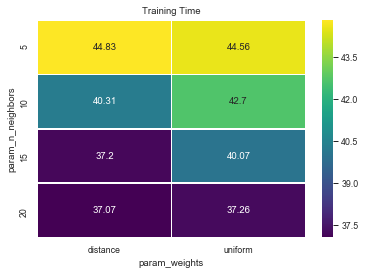

In [123]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_training-time.png", dpi=100)

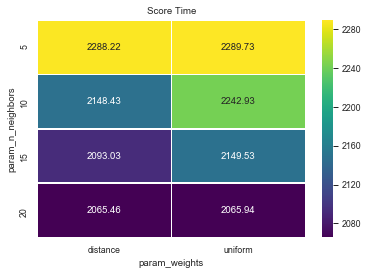

In [124]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_score-time.png", dpi=100)

In [125]:
allAccuracy

[['Neural Network', 'MNIST', 0.9779],
 ['Neural Network', 'Credit', 0.7179542050074899],
 ['Decision Tree', 'MNIST', 0.8833],
 ['Decision Tree', 'Credit', 0.8030173336186603],
 ['Boosting', 'MNIST', 0.973],
 ['Boosting', 'Credit', 0.9238176760111277],
 ['KNN', 'MNIST', 0.9691]]

[learning_curve] Training set sizes: [ 3000  9750 16500 23250 30000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  3.7min remaining: 14.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 30.5min remaining: 30.5min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 41.6min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 50.9min finished


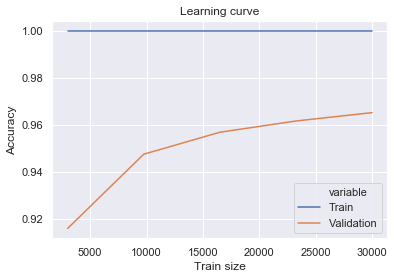

In [126]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "KNN_MNIST_learning-curve.png", dpi=100)

### Credit default

In [127]:
param_grid = {'n_neighbors': np.arange(5, 25, 5), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
kNN.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:  2.1min remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': array([ 5, 10, 15, 20]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [128]:
preds = kNN.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['KNN', 'Credit', accuracy_score(preds, y_test)])

0.849882302589343


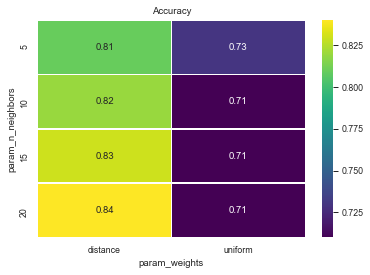

In [129]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_accuracy.png", dpi=100)

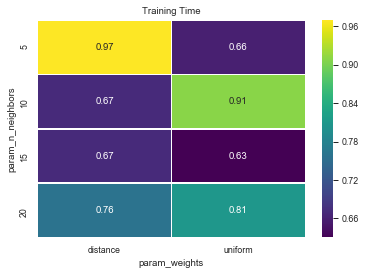

In [130]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_training-time.png", dpi=100)

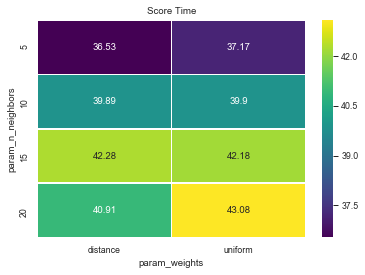

In [131]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 1869  6074 10280 14485 18691]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   13.4s remaining:   31.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   47.9s remaining:   20.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


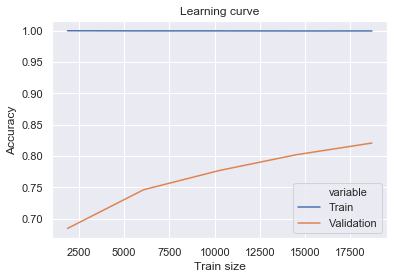

In [132]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=2,
                                            n_jobs=-1,
                                            verbose=3
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "KNN_CREDIT_learning-curve.png", dpi=100)

## SVM

### MNIST

In [133]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': [10, 500, 2000]}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
SVM.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = SVM.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['SVM', 'MNIST', accuracy_score(preds, y_test_MNIST)])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed: 28.9min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 34.2min finished
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
0.9797


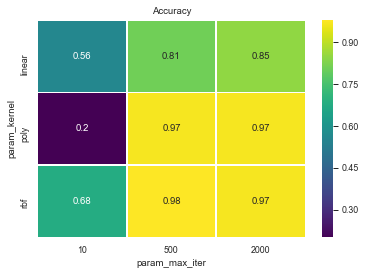

In [134]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_accuracy.png", dpi=100)

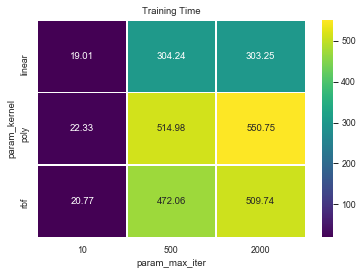

In [135]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_training-time.png", dpi=100)

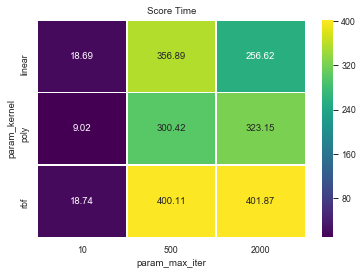

In [136]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 4000 13000 22000 31000 40000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  6.9min remaining: 19.0min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 13.9min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 23.7min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 29.5min finished


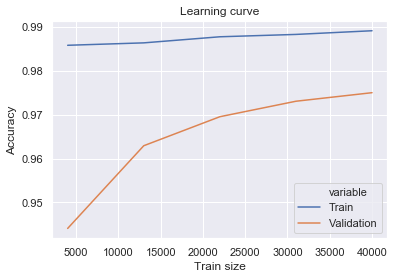

In [137]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=3,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "SVM_MNIST_learning-curve.png", dpi=100)

### Credit default

In [138]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': [10, 500, 2000, 10000, 30000]}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy', cv=3
    )
SVM.fit(X_train, y_train)

preds = SVM.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['SVM', 'Credit', accuracy_score(preds, y_test)])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.7min finished
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
0.6625294243526643


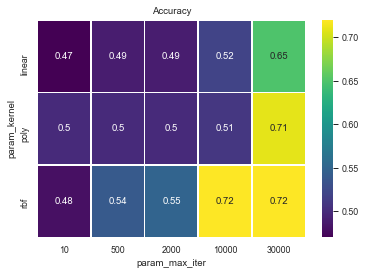

In [139]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_accuracy.png", dpi=100)

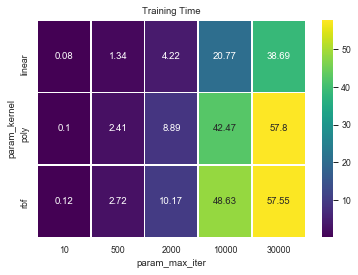

In [140]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_training-time.png", dpi=100)

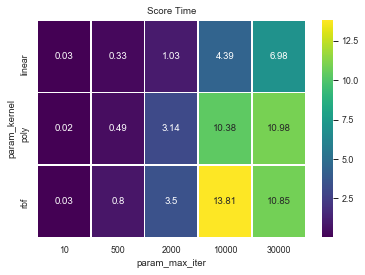

In [141]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_score-time.png", dpi=100)

[learning_curve] Training set sizes: [ 2492  8099 13706 19313 24921]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   14.9s remaining:   40.8s
/anaconda3/envs/ml/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   33.8s remaining:   29.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.2min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished


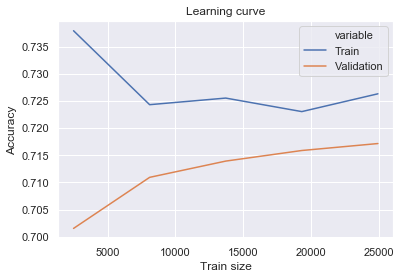

In [142]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=3,
                                            n_jobs=-1,
                                            verbose=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve')
sns_plot.get_figure().savefig(savePath + "SVM_CREDIT_learning-curve.png", dpi=100)

In [143]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9779], ['Neural Network', 'Credit', 0.7179542050074899], ['Decision Tree', 'MNIST', 0.8833], ['Decision Tree', 'Credit', 0.8030173336186603], ['Boosting', 'MNIST', 0.973], ['Boosting', 'Credit', 0.9238176760111277], ['KNN', 'MNIST', 0.9691], ['KNN', 'Credit', 0.849882302589343], ['SVM', 'MNIST', 0.9797], ['SVM', 'Credit', 0.6625294243526643]]


In [144]:
# allAccuracy = [
#     ['Neural Network', 'MNIST', 0.9806], 
#     ['Neural Network', 'Credit', 0.7261930237534774], 
#     ['Decision Tree', 'MNIST', 0.8836], 
#     ['Decision Tree', 'Credit', 0.8031243312647122],
#     ['Boosting', 'MNIST', 0.973], 
#     ['Boosting', 'Credit', 0.9033811256152364],
#     ['KNN', 'MNIST', 0.9691], 
#     ['KNN', 'Credit', 0.8400385191525787], 
#     ['SVM', 'MNIST', 0.979], 
#     ['SVM', 'Credit', 0.66252]
#     ]

In [145]:
allAccuracy = pd.DataFrame(
    allAccuracy,
    columns=['Algorithm', 'Dataset', 'Accuracy']
)

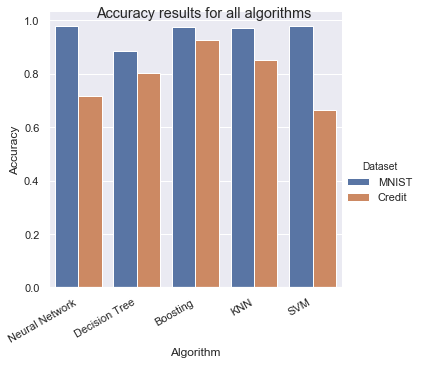

In [146]:
sns.set(
    style="darkgrid"
    )

sns_plot = sns.catplot(
    x="Algorithm", y="Accuracy",
    hue="Dataset",
    data=allAccuracy,
    kind='bar'
    )
    
sns_plot.fig.suptitle('Accuracy results for all algorithms')
# sns_plot.ax.set_xticklabels(sns_plot.ax.get_xticklabels(), rotation=90, ha="right")
sns_plot.fig.autofmt_xdate()
    
sns_plot.fig.savefig(savePath + "all_results.png", dpi=100)

# END